In [1]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [2]:
# setup config
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = 'Human-Segmentation-Dataset-master/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [3]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [4]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

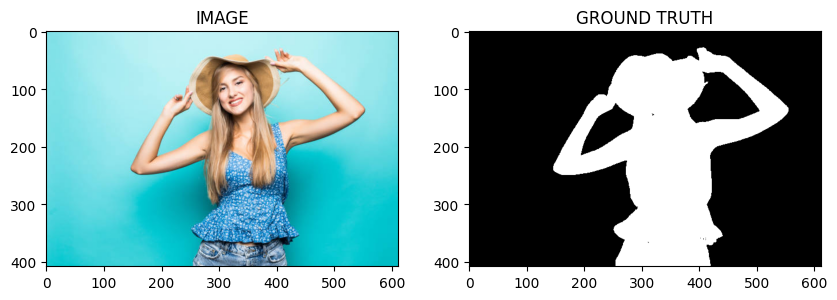

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
# augmentation
import albumentations as A

In [8]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ])

def get_val_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE)
    ])

In [9]:
# custom dataset
from torch.utils.data import Dataset

In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # h, w
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # add channel
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # h, w, c to c, h, w

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        # np to tensor
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [11]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(val_df, get_val_augs())

In [12]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


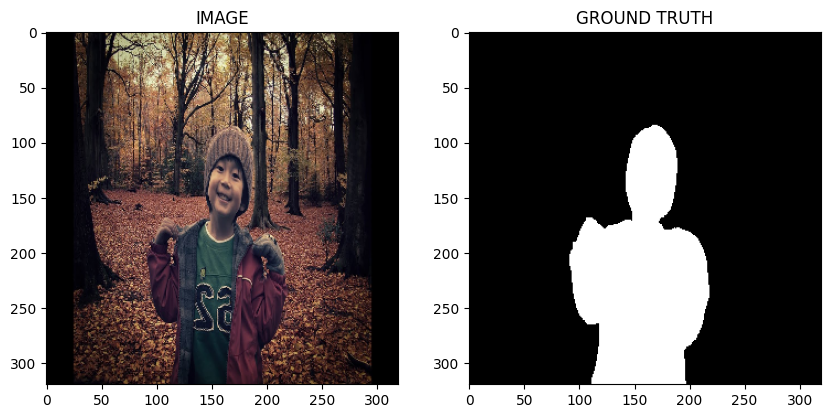

In [13]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

In [14]:
# load dataset into batches
from torch.utils.data import DataLoader

In [15]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [16]:
print(f"Total batches in trainloader: {len(trainloader)}")
print(f"Total batches in validloader: {len(validloader)}")

Total batches in trainloader: 15
Total batches in validloader: 4


In [17]:
for image, mask in trainloader:
    break
    
# batch size, channels, image dims
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


In [18]:
# segmentation model
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [19]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )
        
    def forward(self, images, masks=None):
        logits = self.arc(images)
        
        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            
            return logits, loss1 + loss2
        
        return logits

In [21]:
model = SegmentationModel()
model.to(DEVICE);

In [22]:
# train and valid functions
def train(dataloader, model, optimizer):
    model.train()
    total_loss = 0.0
    
    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        
        logits, loss = model(images, masks)
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [25]:
def evaluate(dataloader, model):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(dataloader)

In [26]:
# train model
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [27]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train(trainloader, model, optimizer)
    valid_loss = evaluate(validloader, model)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best.pt')
        print("Model saved")
        best_valid_loss = valid_loss
        
    
    print(f"Epoch: {i+1} Train loss: {train_loss} Valid loss: {valid_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Model saved
Epoch: 1 Train loss: 0.8779231369495392 Valid loss: 0.5877244174480438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.85it/s]


Epoch: 2 Train loss: 0.40374786257743833 Valid loss: 0.9605509787797928


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.24it/s]


Model saved
Epoch: 3 Train loss: 0.3362025101979574 Valid loss: 0.3551291301846504


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.57it/s]


Model saved
Epoch: 4 Train loss: 0.27999806106090547 Valid loss: 0.26106104999780655


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Model saved
Epoch: 5 Train loss: 0.25723869502544405 Valid loss: 0.24683325365185738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58it/s]


Model saved
Epoch: 6 Train loss: 0.24302833477656047 Valid loss: 0.2373916395008564


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Epoch: 7 Train loss: 0.21015625894069673 Valid loss: 0.25807463377714157


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.69it/s]


Model saved
Epoch: 8 Train loss: 0.1758211851119995 Valid loss: 0.19496480002999306


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.95it/s]


Epoch: 9 Train loss: 0.2175326645374298 Valid loss: 0.24854836612939835


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch: 10 Train loss: 0.19652431706587473 Valid loss: 0.24145764857530594


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.71it/s]


Model saved
Epoch: 11 Train loss: 0.1869618386030197 Valid loss: 0.19170301035046577


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.27it/s]


Epoch: 12 Train loss: 0.1673588529229164 Valid loss: 0.1941247098147869


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.95it/s]


Epoch: 13 Train loss: 0.1549940824508667 Valid loss: 0.24012025445699692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  4.00it/s]


Epoch: 14 Train loss: 0.1833002080519994 Valid loss: 0.256992444396019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.27it/s]


Epoch: 15 Train loss: 0.1533395325144132 Valid loss: 0.22529751807451248


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.76it/s]


Model saved
Epoch: 16 Train loss: 0.1622760072350502 Valid loss: 0.1910863146185875


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.97it/s]


Epoch: 17 Train loss: 0.1405559092760086 Valid loss: 0.19400868192315102


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.68it/s]


Epoch: 18 Train loss: 0.1330999806523323 Valid loss: 0.19424962997436523


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.02it/s]


Model saved
Epoch: 19 Train loss: 0.11497664501269658 Valid loss: 0.18587952479720116


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch: 20 Train loss: 0.10172260055939357 Valid loss: 0.1935091596096754


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70it/s]


Model saved
Epoch: 21 Train loss: 0.09397006382544836 Valid loss: 0.17352118529379368


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.79it/s]


Epoch: 22 Train loss: 0.10136500050624211 Valid loss: 0.19756139814853668


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74it/s]


Epoch: 23 Train loss: 0.12513152460257213 Valid loss: 0.19977973960340023


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.92it/s]


Epoch: 24 Train loss: 0.15501029044389725 Valid loss: 0.27339768782258034


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.79it/s]

Epoch: 25 Train loss: 0.1281990572810173 Valid loss: 0.2054002694785595


In [28]:
# inference

idx = 20

model.load_state_dict(torch.load('best.pt'))

image, mask = validset[idx]

# c h w to 1 c h w
logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5)*1.0

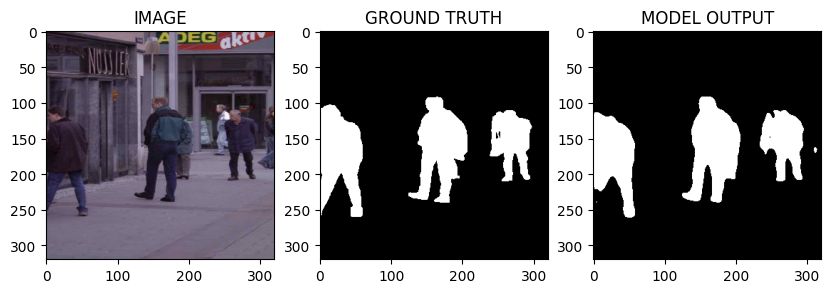

In [29]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))